# Cargando librerías

In [1]:
!python --version

Python 3.8.0


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.mobilenet import preprocess_input
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout,Flatten,Dense,Activation
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing import image

import math

from mlxtend.evaluate import confusion_matrix
import itertools

In [4]:
K.clear_session()

# Cargando Datos

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#train = "/content/drive/MyDrive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Entrenamiento"
train = "C:/Users/DELL/Google Drive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Entrenamiento"
#test = "/content/drive/MyDrive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Validacion"
test = "C:/Users/DELL/Google Drive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Validacion"

# Estableciendo parámetros

In [7]:
"""
HyperParametro
"""
epocas = 61
longitud, altura = 128, 128
#longitud, altura = 256, 256
batch_size = 24

filtroConv1 = 64
filtroConv2 = 32
filtroConv3 = 128

tamano_filtro1 = (50,50)
#tamano_filtro1 = (3,3)
tamano_filtro2 = (3,3)
tamano_filtro3 = (3,3)

tamano_pool = (2,2)
clases = 2

#lr = 0.000400
lr = 0.000200
#lr = 0.001

# Preparando los datos

### ImageDataGenerator

In [8]:
# Preparamos nuestras imágenes

train_datagen = ImageDataGenerator(
    rescale=1. /255,
    shear_range = 0.2,
    zoom_range = 0.0,
    rotation_range=0.0,
    vertical_flip=False,
    horizontal_flip = False
)

test_datagen = ImageDataGenerator(
    rescale=1. /255,
)

### flow_from_directory

In [9]:
# va abrir y preparar toda la carpeta de entrenamiento
imagen_train = train_datagen.flow_from_directory(
    train,
    target_size = (altura, longitud),
    batch_size = batch_size,
    class_mode="categorical",
    color_mode='grayscale'
)

imagen_test = test_datagen.flow_from_directory(
    test,
    target_size=(altura,longitud),
    batch_size=batch_size,
    class_mode="categorical",
    color_mode='grayscale'
)

Found 7200 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


### Clases

In [10]:
print(imagen_train.class_indices)

{'10_cent': 0, '20_cent': 1}


In [11]:
pasos_entrenamiento = imagen_train.n//imagen_train.batch_size
pasos_validacion = imagen_test.n//imagen_test.batch_size
print(pasos_entrenamiento)
print(pasos_validacion)

300
2


### Observando los inputs

In [12]:
type(imagen_train)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [13]:
%%time
fig, axs = plt.subplots(6, 6, figsize=(15,15))

for i in range(6):
  for j in range(6):
    axs[i, j].imshow(imagen_train[i][0][j].reshape(128,128), cmap='gray')

Wall time: 5.6 s


# Modelando

In [14]:
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.layers import BatchNormalization

cnn = Sequential()

# Feature Learning
cnn.add(Convolution2D(64,(4,4),padding='same',input_shape=(128,128,1),activation='relu'))
#cnn.add(Convolution2D(128,(2,2),padding='same',activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(128, activation='relu', kernel_regularizer=l1(0.00005), bias_regularizer=l2(0.00005)))
cnn.add(BatchNormalization())
cnn.add(Dense(256, activation='relu', kernel_regularizer=l1(0.00005), bias_regularizer=l2(0.00005)))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu', kernel_regularizer=l1(0.00005), bias_regularizer=l2(0.00005)))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu', kernel_regularizer=l1(0.00005), bias_regularizer=l2(0.00005)))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu', kernel_regularizer=l1(0.00005), bias_regularizer=l2(0.00005)))
cnn.add(BatchNormalization())

cnn.add(Dropout(0.11))

cnn.add(Dense(clases, activation='softmax'))

In [15]:
%%time
cnn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy']
    )

H = cnn.fit(
    imagen_train,
    steps_per_epoch=pasos_entrenamiento,
    epochs=epocas,
    validation_data=imagen_test,
    validation_steps=pasos_validacion
    )

Epoch 1/61
300/300 [==============================] - 64s 195ms/step - loss: 5.3830 - accuracy: 0.6988 - val_loss: 5.6759 - val_accuracy: 0.4583
Epoch 2/61
300/300 [==============================] - 43s 143ms/step - loss: 3.8207 - accuracy: 0.9219 - val_loss: 4.0406 - val_accuracy: 0.6875
Epoch 3/61
300/300 [==============================] - 38s 126ms/step - loss: 3.2482 - accuracy: 0.9448 - val_loss: 3.9832 - val_accuracy: 0.7083
Epoch 4/61
300/300 [==============================] - 47s 157ms/step - loss: 2.8094 - accuracy: 0.9630 - val_loss: 2.9724 - val_accuracy: 0.8125
Epoch 5/61
300/300 [==============================] - 56s 186ms/step - loss: 2.7275 - accuracy: 0.9518 - val_loss: 3.7170 - val_accuracy: 0.7083
Epoch 6/61
300/300 [==============================] - 52s 174ms/step - loss: 2.5847 - accuracy: 0.9718 - val_loss: 2.5827 - val_accuracy: 0.9375
Epoch 7/61
300/300 [==============================] - 63s 209ms/step - loss: 2.3192 - accuracy: 0.9734 - val_loss: 2.7545 - val_ac

# Resultados del modelo

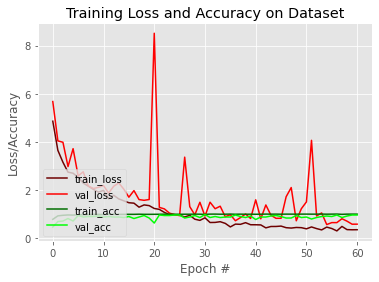

In [16]:
import numpy as np
N = epocas
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N), H.history['loss'], label='train_loss', c='#6E0000')
plt.plot(np.arange(0,N), H.history['val_loss'], label='val_loss', c='#FF0000')
plt.plot(np.arange(0,N), H.history['accuracy'], label='train_acc', c='#006E01')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label='val_acc', c='#00FF03')
plt.title('Training Loss and Accuracy on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('plot.png')

# Testeando el modelo

In [17]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    #directory="/content/drive/MyDrive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Pruebas",
    directory="C:/Users/DELL/Google Drive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Pruebas",
    target_size=(altura, longitud),
    color_mode='grayscale',
    batch_size=3,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 21 images belonging to 1 classes.


In [18]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_generator.reset()
pred = cnn.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

C:\Users\DELL\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
7/7 [==============================] - 4s 24ms/step


In [19]:
predicted_class_indices=np.argmax(pred,axis=1)

In [20]:
print(predicted_class_indices)
print(len(predicted_class_indices))

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
21


In [21]:
labels=(imagen_train.class_indices)

In [31]:
print((imagen_train.class_indices))

{'10_cent': 0, '20_cent': 1}


In [22]:
labels=dict((v,k) for k,v in labels.items())
predictions=[labels[k] for k in predicted_class_indices]

In [23]:
filenames=test_generator.filenames
results=pd.DataFrame({'Filename':filenames,
                      'Predictions':predictions})
results.to_csv('results1.csv', index=False)

In [24]:
real_class_indices=[]
for i in range(0,len(filenames)):
    your_path = filenames[i]
    path_list = your_path.split(os.sep)
    if ('10_cent' in path_list[1]):
        real_class_indices.append(0)
    #if ('1_sol' in path_list[1]):
    #    real_class_indices.append(1)
    if ('20_cent' in path_list[1]):
        real_class_indices.append(1)
    #if ('50_cent' in path_list[1]):
    #    real_class_indices.append(3)
    #if ('5_soles' in path_list[1]):
    #    real_class_indices.append(4)
#{'10_cent': 0, '1_sol': 1, '20_cent': 2, '50_cent': 3, '5_soles': 4}
#'10_cent': 0, '1_sol': 1, '20_cent': 2, '50_cent': 3, '5_soles': 4
print(real_class_indices)
print(len(real_class_indices))
#real_class_indices = np.array(real_class_indices)


[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
21


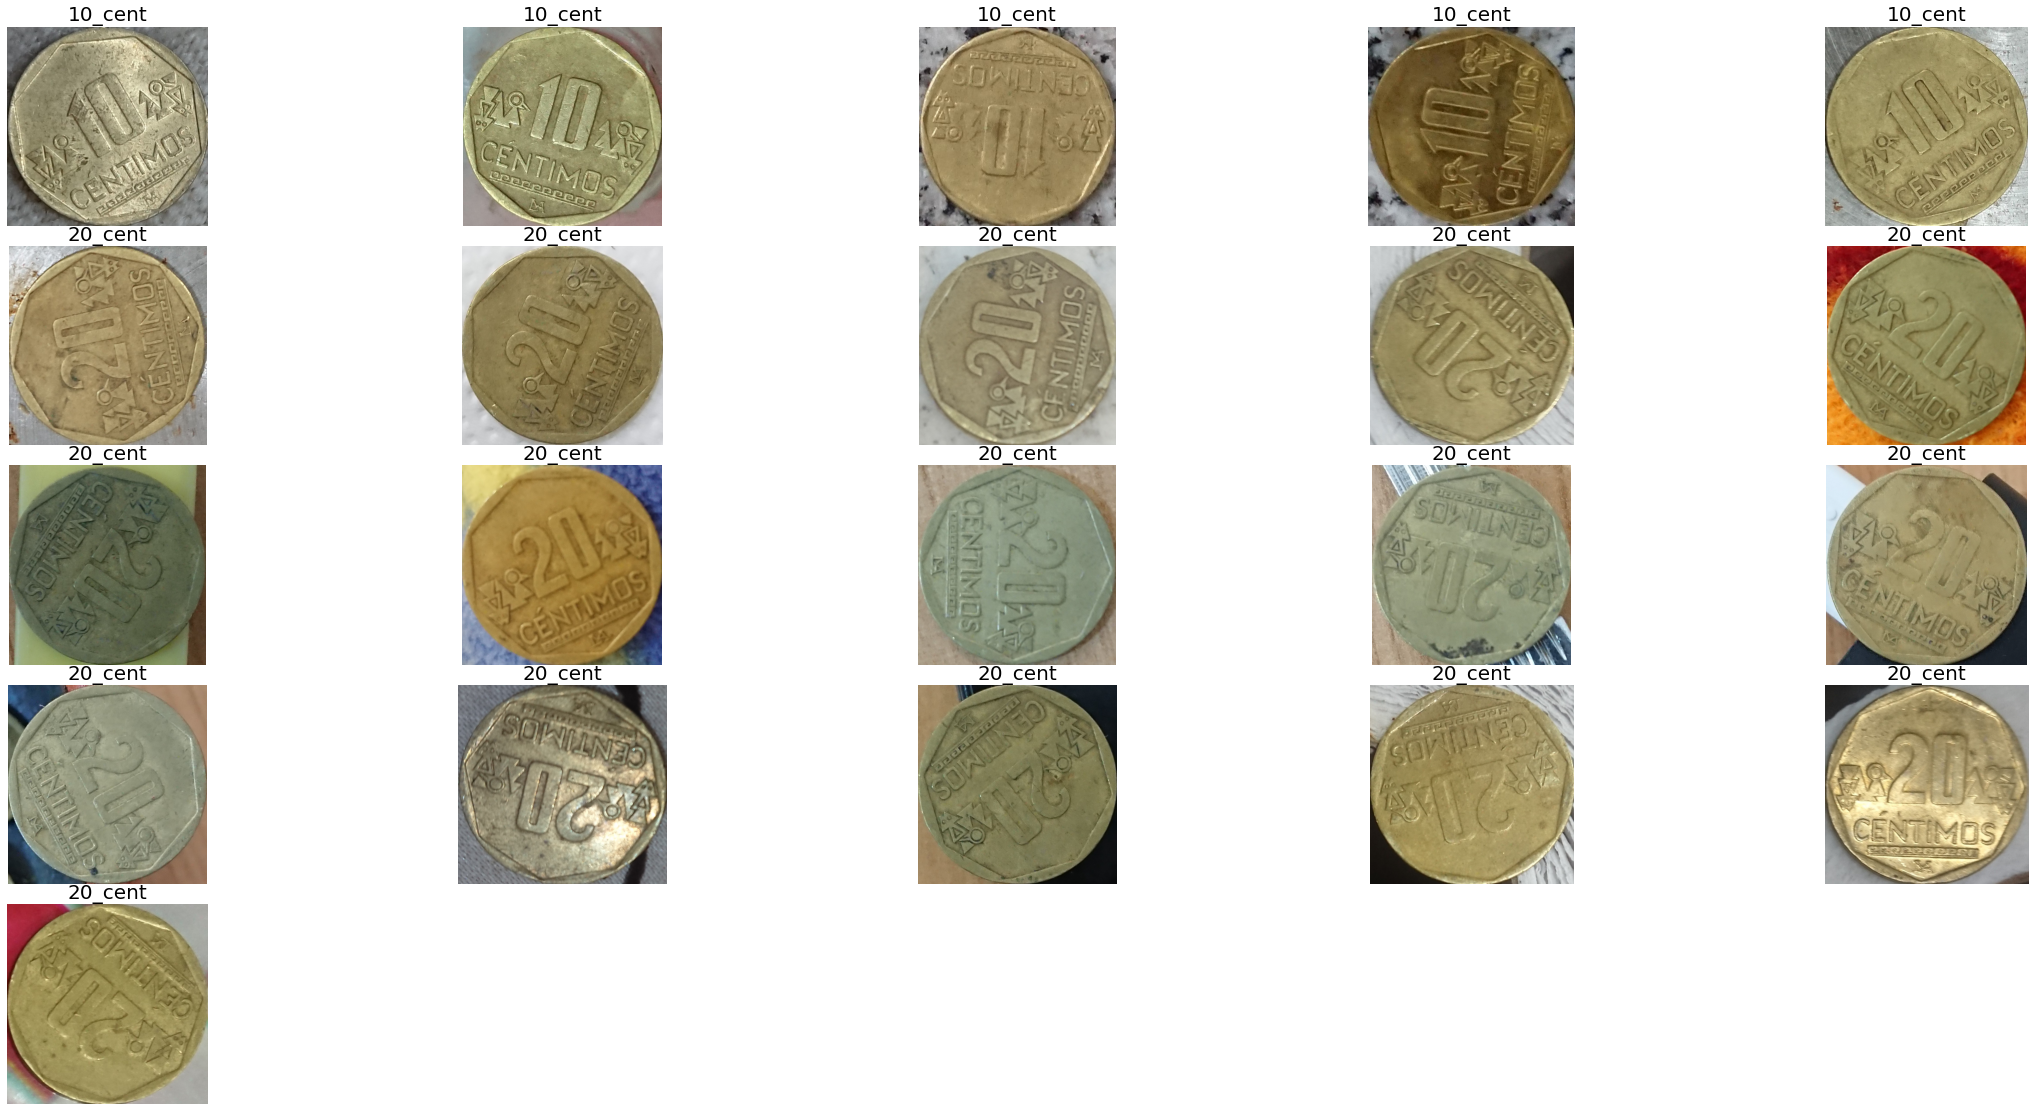

In [25]:
fig = plt.figure(figsize=(40,40))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
rows=10
cols=len(filenames)//rows if len(filenames)%2 == 0 else len(filenames)//rows + 1
cols=5
#folder = '/content/drive/MyDrive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Pruebas/test_images/'
folder = "C:/Users/DELL/Google Drive/Clasificacion-de-monedas-peruanas-con-Redes-Neuronales-Convolucionales/Datos/Pruebas/test_images/"
for i in range(0,len(filenames)):
    your_path = filenames[i]
    path_list = your_path.split(os.sep)
    #print(path_list)
    img = mpimg.imread(folder+path_list[1])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('Off')
    plt.imshow(img, interpolation=None)
    ax.set_title(predictions[i], fontsize=20)


In [26]:
cm = confusion_matrix(real_class_indices, predicted_class_indices)

In [27]:
cm

array([[ 5,  0],
       [ 0, 16]])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by settings 'normaliza=True'
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', color='white' if cm[i,j] > thresh else 'black')
        plt.tight_layout()
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
    
    plt.savefig('mc.png')

In [32]:
print(imagen_train.class_indices)

{'10_cent': 0, '20_cent': 1}


In [29]:
cm_plot_labels = imagen_train.class_indices
plot_confusion_matrix(cm, cm_plot_labels, title='Matriz de Confusión')

Confusion matrix, without normalization


In [30]:
cnn.save('Modelo/modelo1.h5')
cnn.save_weights('Modelo/pesos1.h5')